In [1]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion
from PIL import Image
from plot_ee_fctns import get_image_index, box_around_point, mask_other, initialise_comparison
from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection, MODIS_mask_clouds_250m
import masks
import data_cleaning

# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)
root_directory = ''
country_codes = {'DE': 93,
                     'KEN': 133}
product_codes = {'M': 'product == "maize"',
                 'ww': 'product == "wintercereals"'}

In [26]:
def plot_smoothed_NDVIs(fig, ax, ds, ds_stds, interp_method = 'MVI', polyorder = 2, window_length = 30,
                       plot_stds = True):
    try:
        ds = ds.reset_index()
    except:
        print('Already reset index')
    try:
        ds_stds = ds_stds.reset_index()
    except:
        print('Already reset index')
    #ds_lower = ds.copy()
    ds = ds.merge(ds_stds, on = ['date'], how = 'inner', suffixes = ['', ' std'])
    #ds_lower['NDVI'] = ds['NDVI'] - ds_stds['NDVI']
    #ds_upper = ds.copy()
    #ds_upper['NDVI'] = ds['NDVI'] + ds_stds['NDVI']
    if interp_method == 'linear':
        #ds = ds.drop('date', axis = 1)
        ds_interpolated = data_cleaning.resample_linear(ds)
        ds_interpolated.rename(columns={'time': 'date'}, inplace=True)
        #ds_interpolated_lower = resample_linear(ds_lower)
        #ds_interpolated_upper = resample_linear(ds_upper)
    elif interp_method == 'MVI':
        ds_interpolated = data_cleaning.max_value_int(ds, window_size=16) #data_cleaning.
        #try:
            #ds_interpolated_lower = data_cleaning.max_value_int(ds_lower, window_size=10)
            #ds_interpolated_upper = data_cleaning.max_value_int(ds_upper, window_size=10)
            #plot_stds = True
        #except:
        #    print('issue with standard deviations')
        #    plot_stds = False
    try:
        ax.plot(ds_interpolated['date'], scipy.signal.savgol_filter(ds_interpolated['NDVI'], window_length=window_length, polyorder=polyorder, deriv = 0), label = 'NDVI, S-G smooth', color = 'black')
    except:
        print('savgol failed')
    ax.plot(ds_interpolated['date'], ds_interpolated['NDVI'], label = 'NDVI, maximum value interpolation', color = 'red')
    if plot_stds:
        ax.fill_between(ds_interpolated['date'], 
                        ds_interpolated['NDVI'] - ds_interpolated['NDVI std'], 
                        ds_interpolated['NDVI'] + ds_interpolated['NDVI std'], 
                        alpha = 0.5, color='red')
    ax.set_ylim(0, 1)

In [3]:
def dates_on_plot(axs, coord, year,
                 WC_dates = False, CIMMYT = False, TAMASA=True):
    if WC_dates:
        dates = get_SOS_EOS(coord[0], coord[1])
        axs.axvline(x=np.datetime64(f'{year}-01-01') + np.timedelta64(dates[0], 'D'), 
                    label='main season start', linestyle = ':', color = 'green')
        axs.axvline(x=np.datetime64(f'{year}-01-01') + np.timedelta64(dates[1], 'D'), 
                    label='main season end', linestyle = '--', color = 'green')
        if len(dates) > 2:
            axs.axvline(x=np.datetime64(f'{year}-01-01') + np.timedelta64(dates[2], 'D'),
                        label='second season start', linestyle = ':', color = 'red')
            axs.axvline(x=np.datetime64(f'{year}-01-01') + np.timedelta64(dates[3], 'D'), 
                        label='second season end', linestyle = '--', color = 'red')
    else:
        if TAMASA:
            dates = coord[3:]
            axs.axvline(x=pd.to_datetime(dates[0], dayfirst=True), 
                        label='planting date', linestyle = ':', color = 'green')
            axs.axvline(x=pd.to_datetime(dates[1]), 
                        label='emergence date', linestyle = '--', color = 'green')
            try:
                axs.axvline(x=pd.to_datetime(dates[2]),
                            label='flowering date', linestyle = ':', color = 'red')
            except:
                print('flowering date was a nan')
            try:
                axs.axvline(x=pd.to_datetime(dates[3]), 
                            label='maturity date', linestyle = '--', color = 'red')
            except:
                print('maturity date was a nan')
        elif CIMMYT:
            dates = coord[3:]
            try:
                axs.axvline(x=pd.to_datetime(dates[0]),
                            label='planting date', linestyle = ':', color = 'red')
            except:
                print('planting date was a nan')
            try:
                axs.axvline(x=pd.to_datetime(dates[1]),
                            label='flowering date', linestyle = ':', color = 'red')
            except:
                print('flowering date was a nan')
            try:
                axs.axvline(x=pd.to_datetime(dates[2]), 
                            label='silking date', linestyle = '--', color = 'red')
            except:
                print('silking date was a nan')

In [4]:
dataset4 = ee.Image('projects/ee-martinparker637/assets/Kenya_MODIS_masks/GFSAD_Dominance')

In [5]:
dataset4.bandNames().getInfo()

['b1']

In [6]:
kenya = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1').filter(ee.Filter.eq('ADM0_NAME', 'Kenya'))

In [ ]:
dataset4.geetools.plot(
    bands = ["b1"],
    region=kenya.geometry(),
)

/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


In [4]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=1200, bestEffort=True)
def addNDVI(image, bands = ['sur_refl_b02', 'sur_refl_b01']):
    ndvi = image.normalizedDifference(bands).rename('NDVI')
    return image.addBands([ndvi])

In [5]:
def get_SOS_EOS(lat, lon):
    AEZs = ee.FeatureCollection("ESA/WorldCereal/AEZ/v100")
    point = ee.Geometry.Point([lon, lat])
    containingFeatures = AEZs.filterBounds(point)
    SOS1 = containingFeatures.aggregate_array('tc-maize-main_sos').getInfo()[0]
    EOS1 = containingFeatures.aggregate_array('tc-maize-main_eos').getInfo()[0]
    SOS2 = containingFeatures.aggregate_array('tc-maize-second_sos').getInfo()
    if len(SOS2) != 0:
        SOS2 = SOS2[0]
        EOS2 = containingFeatures.aggregate_array('tc-maize-second_eos').getInfo()[0]
        return [SOS1, EOS1, SOS2, EOS2]
    else:
        return [SOS1, EOS1]

In [9]:
def MODIS_at_single_point(coords, year=2016, WC_dates = True, TAMASA=True, CIMMYT = False, suptitle = 'Single pixel MODIS timeseries'):
    fig, ax = plt.subplots(1, len(coords), figsize = (5*len(coords), 5))
    font_size = 15
    for coord_index, coord in enumerate(coords):
        if CIMMYT:
            year = int(np.round(coord[-1]))
        axs = ax[coord_index]
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(2000),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection("MODIS/061/MOD09GQ").filterBounds(f1c)
        IC = IC.filterDate(f'{year-1}-12-01',f'{year}-12-31')
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        ts = getTimeSeriesByRegion(IC,
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                   geometry = ee.Geometry.Point([coord[1],coord[0]]), #ee.Geometry.Point([coord[1],coord[0]]).buffer(5000), 
                                   bands = ['NDVI'], scale = 250)
        try:
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
        except:
            print('region empty')
            continue
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x['NDVI']!=-9999).dropna()
        xreduced = x.where(x['reducer'] == 'mean').dropna()
        xstd = x.where(x['reducer'] == 'stdDev').dropna()
        axs.tick_params(labelrotation=45)
        axs.set_xlabel('Day of year', fontsize = font_size)
        axs.set_ylabel('Average NDVI', fontsize = font_size)
        dates_on_plot(axs, coord, year, WC_dates = WC_dates, CIMMYT = CIMMYT, TAMASA=TAMASA)
        plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = 'MVI', window_length = 14, plot_stds=False)
        axs.set_title(f'{coord[2]}, year {year}:\nlon {coord[1]},\nlat {coord[0]}', fontsize = font_size + 3)
        if coord_index == 0:
            fig.legend(prop={'size': font_size}, bbox_to_anchor = (1.3, 0.7))
    fig.suptitle(suptitle, fontsize = font_size + 3)
    fig.tight_layout()

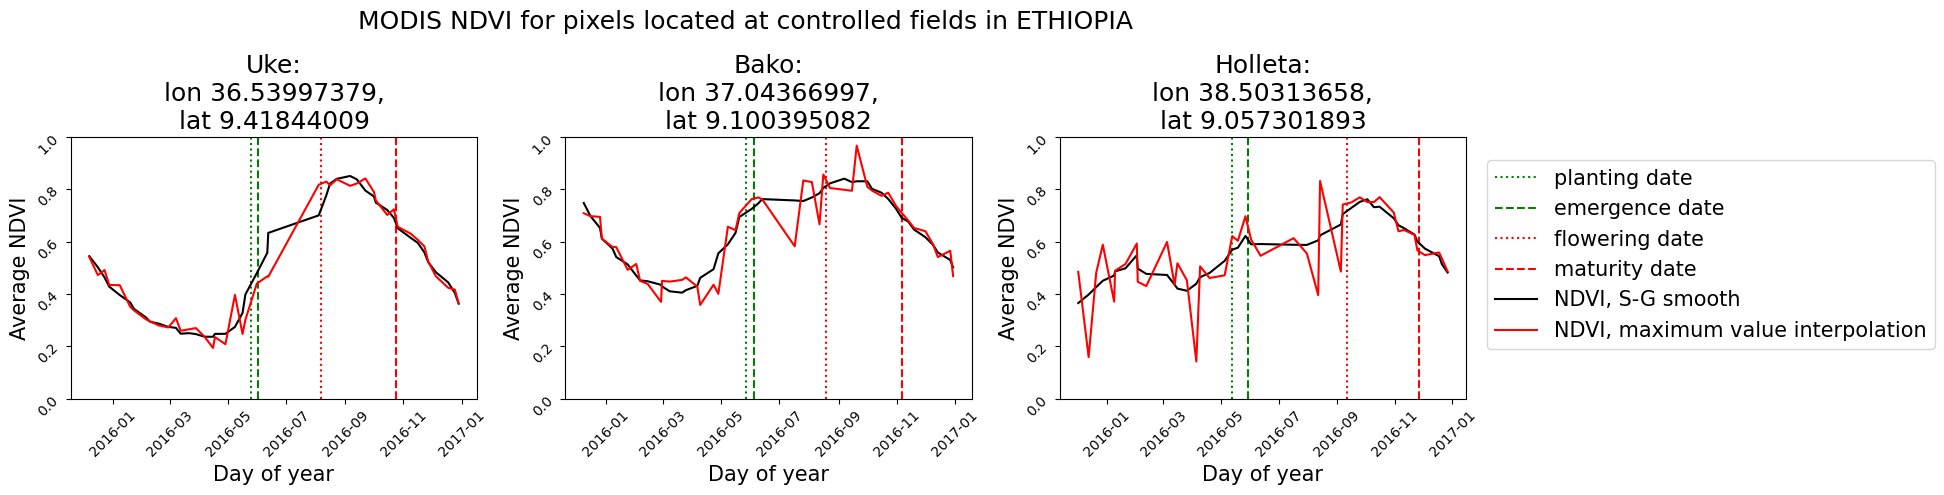

In [143]:
MODIS_at_single_point(coords=c_ET[[2, 3, 5]], WC_dates = False, suptitle='MODIS NDVI for pixels located at controlled fields in ETHIOPIA')

In [7]:
phen_data_CIMMYT = pd.read_csv('Saved_files/Phen_Data/CIMMY_phen_data.csv')
phen_data_TZ = pd.read_csv('Saved_files/Phen_Data/TAMASA_Tanzania.csv')
phen_data_ET = pd.read_csv('Saved_files/Phen_Data/TAMASA_Ethiopia.csv')

In [7]:
def put_SOS_EOS_in_frame(phen_data):
    phen_data['SOS'] = -999
    phen_data['EOS'] = -999
    phen_data['SOS2'] = -999
    phen_data['EOS2'] = -999
    lat_prev = 1000
    lon_prev = 1000
    for index in phen_data.index:
        lat = phen_data.loc[index]['lat']
        lon = phen_data.loc[index]['lon']
        if (lat_prev != lat or lon_prev != lon) and ~np.isnan(lat):
            SOS_EOS = get_SOS_EOS(lat, lon)
            lat_prev = lat
            lon_prev = lon
            print(lat, lon, SOS_EOS)
        #print(phen_data_CIMMYT.loc[index]['lat'])
        phen_data.loc[index, 'SOS'] = SOS_EOS[0]
        phen_data.loc[index, 'EOS'] = SOS_EOS[1]
        if len(SOS_EOS) > 2:
            phen_data.loc[index, 'SOS2'] = SOS_EOS[2]
            phen_data.loc[index, 'EOS2'] = SOS_EOS[3]
    return(phen_data)

In [130]:
#phen_data_CIMMYT['lat']
#phen_data_ET = put_SOS_EOS_in_frame(phen_data_ET)
#phen_data_TZ = put_SOS_EOS_in_frame(phen_data_TZ)
#phen_data_CIMMYT = put_SOS_EOS_in_frame(phen_data_CIMMYT)
#phen_data_ET.to_csv('Saved_files/Phen_Data/TAMASA_ET.csv')
#phen_data_TZ.to_csv('Saved_files/Phen_Data/TAMASA_TZ.csv')
#phen_data_CIMMYT.to_csv('Saved_files/Phen_Data/CIMMYT_phen_data.csv')

In [8]:
phen_data_ET = pd.read_csv('Saved_files/Phen_Data/TAMASA_ET.csv')
phen_data_TZ = pd.read_csv('Saved_files/Phen_Data/TAMASA_TZ.csv')
phen_data_CIMMYT = pd.read_csv('Saved_files/Phen_Data/CIMMYT_phen_data.csv')

In [101]:
#phen_data_CIMMYT['SOS'] = 1
#lat_prev = 1000
#lon_prev = 1000
#for index in phen_data_CIMMYT.index:
#    print(index)
#    lat = phen_data_CIMMYT.loc[index]['lat']
#    lon = phen_data_CIMMYT.loc[index]['lon']
#    print(lat, lon)
#    if lat_prev != lat or lon_prev != lon:
#        SOS_EOS = get_SOS_EOS(lat, lon)
#        lat_prev = lat
#        lon_prev = lon
#    #print(phen_data_CIMMYT.loc[index]['lat'])
#    phen_data_CIMMYT.loc[index, 'SOS'] = SOS_EOS[0]

In [9]:
c_CIMMYT = pd.read_csv("Saved_files/CIMMYT_coords_2000_2007.csv")
c_CIMMYT = c_CIMMYT.drop_duplicates(subset = ['lat', 'lon', 'sitecode'])
c_CIMMYT = c_CIMMYT[['lat', 'lon', 'sitecode']].values
c_TA = pd.read_csv("Saved_files/TAMASA_Tanzania_coords.csv").drop_duplicates(subset=['station'])[['lat', 'lon', 'station']].values
c_ET = pd.read_csv("Saved_files/TAMASA_Ethiopia_coords.csv").drop_duplicates(subset=['station', 'GPS Coordinate Latitude', 'GPS Coordinate Longitude'])
c_ET = c_ET[['GPS Coordinate Latitude', 'GPS Coordinate Longitude', 'station']].values

In [10]:
print(c_CIMMYT[:, 0].min(), c_CIMMYT[:, 0].max(), c_CIMMYT[:, 1].min(), c_CIMMYT[:, 1].max())

-29.55 11.23 12.2 39.75


In [104]:
#import os
#homedir = '/home/users/wlwc1989/earth_engine_MP/ERA5 land/Africa/CIMMYT/'
#for year in range(1999, 2008):
#    #newpath = f'/home/users/wlwc1989/earth_engine_MP/ERA5 land/Africa/CIMMYT/All_Africa/ar}'
#    newfolder = f'All_Africa/{year}'
#    newpath = os.path.join(homedir, newfolder)
#    if not os.path.exists(newpath):
#        print(year)#, sitecode)
#        os.makedirs(newpath)

In [105]:
#import os
#for coord in c_CIMMYT:
#    sitecode = int(np.round(coord[2]))
#    homedir = '/home/users/wlwc1989/earth_engine_MP/ERA5 land/Africa/CIMMYT/'
#    newfolder = f'location_{sitecode}'
#    newpath = os.path.join(homedir, newfolder)
#    if not os.path.exists(newpath):
#            print(year, sitecode)
#            os.makedirs(newpath)
#    else:
#        os.chdir(newpath)
#        print(os.getcwd())
#    for year in range(1999, 2008):
#        newpath = f'/home/users/wlwc1989/earth_engine_MP/ERA5 land/Africa/CIMMYT/{sitecode}/{year}'
#        newfolder = f'location_{sitecode}/year_{year}'
#        newpath = os.path.join(homedir, newfolder)
#        if not os.path.exists(newpath):
#            print(year, sitecode)
#            os.makedirs(newpath)

In [9]:
c_DE = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
c_TA = pd.read_csv("Saved_files/TAMASA_Tanzania_coords.csv")[['lat', 'lon', 'station', 'planting date', 'emergence date', 'flowering date', 'maturity date']].values
c_ET = pd.read_csv("Saved_files/TAMASA_Ethiopia_coords.csv").drop_duplicates(subset=['station'])[['GPS Coordinate Latitude', 'GPS Coordinate Longitude', 'station', 'planting date', 'emergence date', 'flowering date', 'maturity date']].values #
c_CIMMYT = pd.read_csv("Saved_files/CIMMYT_coords_2000_2007.csv").dropna(subset = ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
c_CIMMYT = c_CIMMYT.where(c_CIMMYT['sitecode'].isin(np.array([1051, 1055, 77, 530, 15, 531]))).dropna(how='all')
#c_CIMMYT = c_CIMMYT.where(c_CIMMYT['sitecode'].isin(np.array([469, 492, 918, 507, 474, 501, 487, 480]))).dropna(how='all')
#c_CIMMYT = c_CIMMYT.where(c_CIMMYT['yrcode'] == 2001).dropna(how = 'all')
for column in ['PlantingDate', 'AnthesisDate', 'DaysToSilk']:
    print(column)
    if column == 'PlantingDate':
        c_CIMMYT[column] = pd.to_datetime(c_CIMMYT.loc[:, column])#.astype('datetime64[ns]')
    else:
        c_CIMMYT[column] = pd.to_datetime(c_CIMMYT.loc[:, column], format = 'mixed')
c_CIMMYT = c_CIMMYT[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].groupby(['sitecode', 'yrcode']).mean()#.drop_duplicates(subset=['sitecode', 'yrcode'])[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].values
c_CIMMYT = c_CIMMYT.reset_index()
c_CIMMYT = c_CIMMYT[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].values

PlantingDate
AnthesisDate
DaysToSilk


In [10]:
np.unique(c_CIMMYT[:, 2])

array([15.0, 77.0, 530.0, 531.0, 1051.0, 1055.0], dtype=object)

In [14]:
#c_TAS = c_TA[:67]
#edge_coords_TA = [[c_TAS[:, 0].max(), c_TAS[:, 1].max(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].max(), c_TAS[:, 1].min(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].max(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].min(), c_TAS[:, 2].max()]]
#MODIS_at_single_point(coords=edge_coords_TA)

In [15]:
#c_TAS = c_TA[67:137]
#edge_coords_TA = [[c_TAS[:, 0].max(), c_TAS[:, 1].max(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].max(), c_TAS[:, 1].min(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].max(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].min(), c_TAS[:, 2].max()]]
#MODIS_at_single_point(coords=edge_coords_TA)

In [63]:
#c_TAS = c_TA[137:217]
#pld = pd.to_datetime(c_TAS[:, 3], dayfirst = True).mean()
#ed = pd.to_datetime(c_TAS[:, 4]).mean()#
#fd = pd.to_datetime(c_TAS[:, 5]).mean()
#md = pd.to_datetime(c_TAS[:, 6]).mean()
#edge_coords_TA = [[c_TAS[:, 0].max(), c_TAS[:, 1].max(), c_TAS[:, 2].max(), pld, ed, fd, md], 
#                  [c_TAS[:, 0].max(), c_TAS[:, 1].min(), c_TAS[:, 2].max(), pld, ed, fd, md],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].max(), c_TAS[:, 2].max(), pld, ed, fd, md],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].min(), c_TAS[:, 2].max(), pld, ed, fd, md]]
#MODIS_at_single_point(coords=edge_coords_TA, WC_dates = False, TAMASA = True, CIMMYT=False)

In [64]:
#c_TAS = c_TA[217:267]
#edge_coords_TA = [[c_TAS[:, 0].max(), c_TAS[:, 1].max(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].max(), c_TAS[:, 1].min(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].max(), c_TAS[:, 2].max()],
#                  [c_TAS[:, 0].min(), c_TAS[:, 1].min(), c_TAS[:, 2].max()]]
#MODIS_at_single_point(coords=edge_coords_TA)

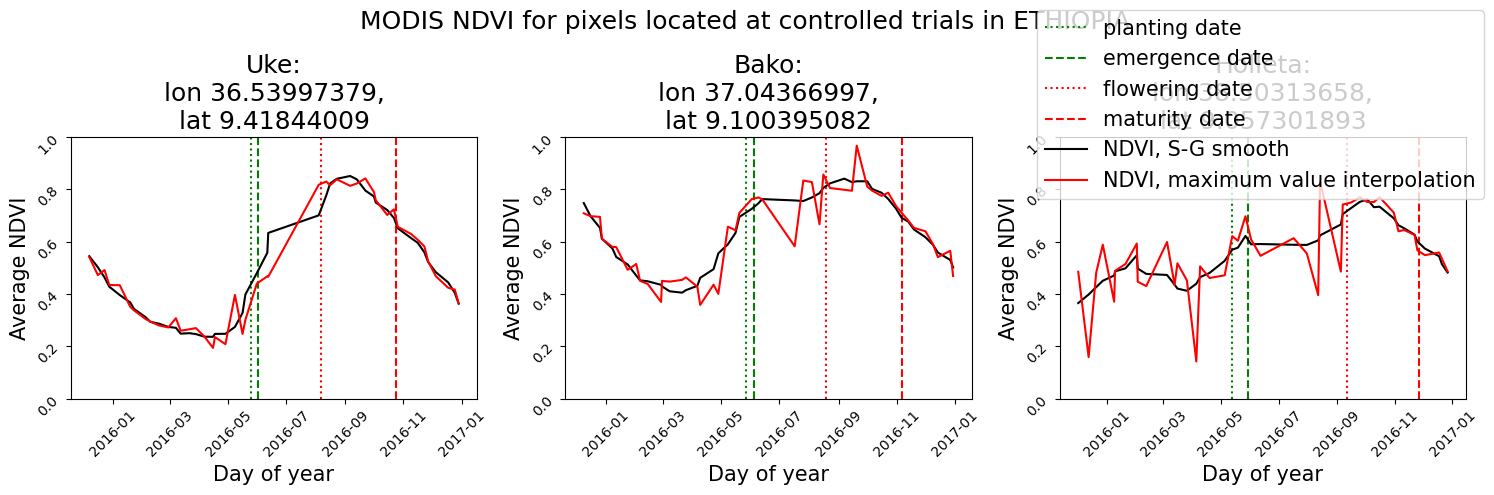

In [136]:
MODIS_at_single_point(coords=c_ET[[2, 3, 5]], WC_dates = False, suptitle='MODIS NDVI for pixels located at controlled trials in ETHIOPIA')

In [12]:
#MODIS_at_single_point(coords=c_TA[:3], WC_dates = False, TAMASA=True, CIMMYT=False)
#c_TA
#MODIS_at_single_point(coords=c_CIMMYT[:5], year = 2005)
#MODIS_at_single_point(coords=c_CIMMYT[5:10], year = 2005)
#MODIS_at_single_point(coords=c_CIMMYT[10:15], year = 2005)
#MODIS_at_single_point(coords=c_CIMMYT[15:20], year = 2005)
#MODIS_at_single_point(coords=c_CIMMYT[20:25], year = 2005)
#MODIS_at_single_point(coords=c_CIMMYT[25:30], year = 2005)
#MODIS_at_single_point(coords=c_CIMMYT[30:35], year = 2005)
#MODIS_at_single_point(coords=kenya_coords, year = 2003, WC_dates=False)
#MODIS_at_single_point(coords=c_CIMMYT, year = 2001, WC_dates=False, CIMMYT = True, TAMASA = False)

In [30]:
def MODIS_at_point_averaged(coords, year=2016,
                           buffer_size = 5000, LULC_mask = True,
                           CIMMYT = True, WC_dates = False,
                           TAMASA = False, suptitle = 'MODIS NDVI Averaged in a 1km radius'):
    font_size = 15
    fig, ax = plt.subplots(1, len(coords), figsize = (5*len(coords), 5))
    for coord_index, coord in enumerate(coords):
        if CIMMYT:
            year = int(np.round(coord[-1]))
        axs = ax[coord_index]
        f1 = ee.Feature(ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size),{'ID':'A'})
        f1c = ee.FeatureCollection([f1])
        IC = ee.ImageCollection("MODIS/061/MOD09GQ").filterBounds(f1c)
        IC = IC.filterDate(f'{year-1}-12-01',f'{year}-12-31')
        IC = MODIS_mask_clouds_250m(IC)
        IC = IC.map(addNDVI)
        if LULC_mask:
            MODIS_LULC = ee.ImageCollection('MODIS/061/MCD12Q1').select('LC_Type1').filterDate(f'{year}-01-01', f'{year}-12-31').mosaic()
            MODIS_cropland = MODIS_LULC.eq(12).Or(MODIS_LULC.eq(14))
            MODIS_cropland = MODIS_cropland.updateMask(MODIS_cropland)
            IC = IC.map(lambda img: img.updateMask(MODIS_cropland))
        ts = getTimeSeriesByRegion(IC,
                                   reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.stdDev()], 
                                   geometry = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size), #ee.Geometry.Point([coord[1],coord[0]]).buffer(5000), 
                                   bands = ['NDVI'], scale = 250)
        try:
            x = geemap.ee_to_df(ts).sort_index(ascending=True)
        except:
            print('region empty')
            continue
        x['date'] = pd.to_datetime(x['date'])
        x = x.where(x['NDVI']!=-9999).dropna()
        xreduced = x.where(x['reducer'] == 'median').dropna() #mean
        xstd = x.where(x['reducer'] == 'stdDev').dropna()
        axs.tick_params(labelrotation=45)
        axs.set_xlabel('Day of year', fontsize = font_size)
        axs.set_ylabel('Average NDVI', fontsize = font_size)
        dates_on_plot(axs, coord, year, WC_dates = WC_dates, CIMMYT = CIMMYT, TAMASA=TAMASA)
        plot_smoothed_NDVIs(fig, axs, xreduced, xstd, interp_method = 'MVI', window_length = 14, plot_stds=True)
        axs.set_title(f'{coord[2]}: lon {coord[1]}, lat {coord[0]}', fontsize = font_size + 3)
        #if coord_index == 0:
        #    fig.legend(prop={'size': font_size})
    fig.suptitle(suptitle, fontsize = font_size + 3)

In [12]:
c_CIMMYT.shape

(35, 7)

In [ ]:
1051, 1055, 77, 530, 15, 531

In [33]:
c_DE = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')
c_TA = pd.read_csv("Saved_files/TAMASA_Tanzania_coords.csv")[['lat', 'lon', 'station', 'planting date', 'emergence date', 'flowering date', 'maturity date']].values
c_ET = pd.read_csv("Saved_files/TAMASA_Ethiopia_coords.csv").drop_duplicates(subset=['station'])[['GPS Coordinate Latitude', 'GPS Coordinate Longitude', 'station', 'planting date', 'emergence date', 'flowering date', 'maturity date']].values #
c_CIMMYT = pd.read_csv("Saved_files/CIMMYT_coords_2000_2007.csv").dropna(subset = ['PlantingDate', 'AnthesisDate', 'DaysToSilk'])
c_CIMMYT = c_CIMMYT.where(c_CIMMYT['sitecode'].isin(np.array([1055]))).dropna(how='all')
#c_CIMMYT = c_CIMMYT.where(c_CIMMYT['sitecode'].isin(np.array([469, 492, 918, 507, 474, 501, 487, 480]))).dropna(how='all')
#c_CIMMYT = c_CIMMYT.where(c_CIMMYT['yrcode'] == 2001).dropna(how = 'all')
for column in ['PlantingDate', 'AnthesisDate', 'DaysToSilk']:
    print(column)
    if column == 'PlantingDate':
        c_CIMMYT[column] = pd.to_datetime(c_CIMMYT.loc[:, column])#.astype('datetime64[ns]')
    else:
        c_CIMMYT[column] = pd.to_datetime(c_CIMMYT.loc[:, column], format = 'mixed')
c_CIMMYT = c_CIMMYT[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].groupby(['sitecode', 'yrcode']).mean()#.drop_duplicates(subset=['sitecode', 'yrcode'])[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].values
c_CIMMYT = c_CIMMYT.reset_index()
c_CIMMYT = c_CIMMYT[['lat', 'lon', 'sitecode', 'PlantingDate', 'AnthesisDate', 'DaysToSilk', 'yrcode']].values

PlantingDate
AnthesisDate
DaysToSilk


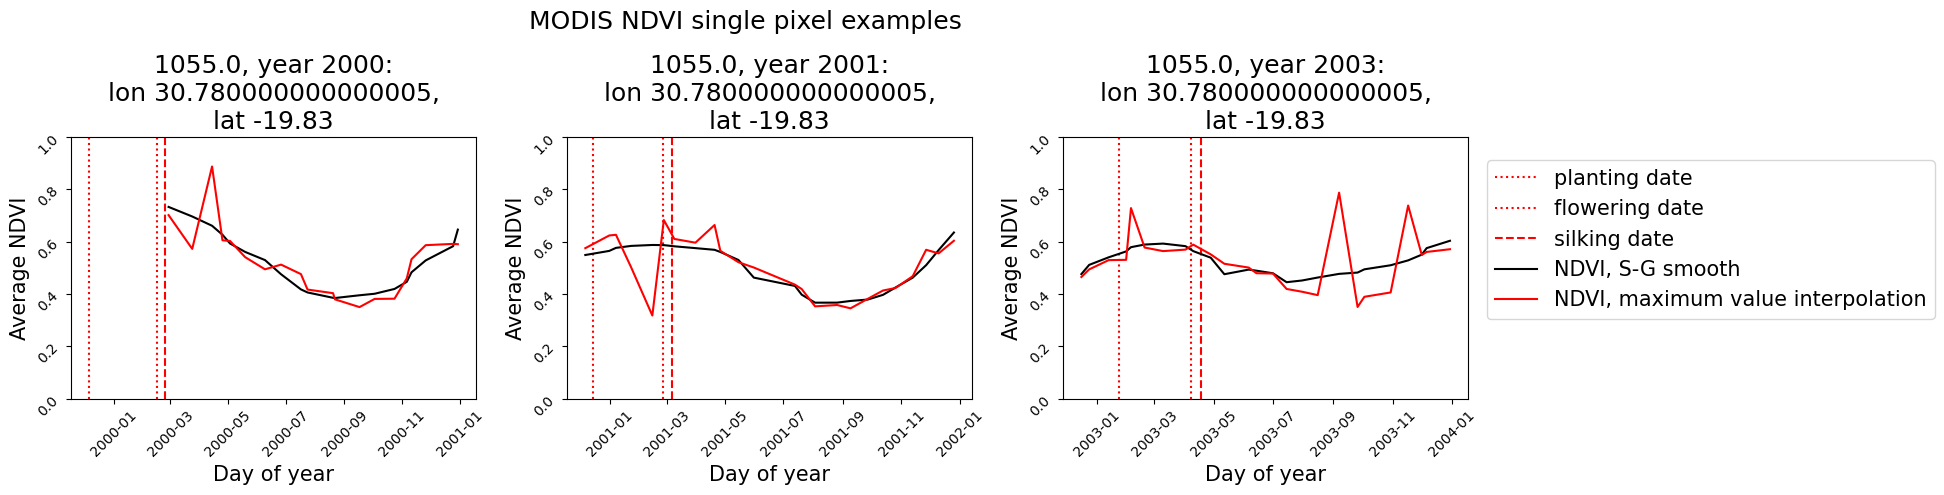

In [34]:
MODIS_at_single_point(coords=c_CIMMYT[:3], year = 2001, WC_dates=False, CIMMYT = True, TAMASA = False,
                     suptitle = 'MODIS NDVI single pixel examples')

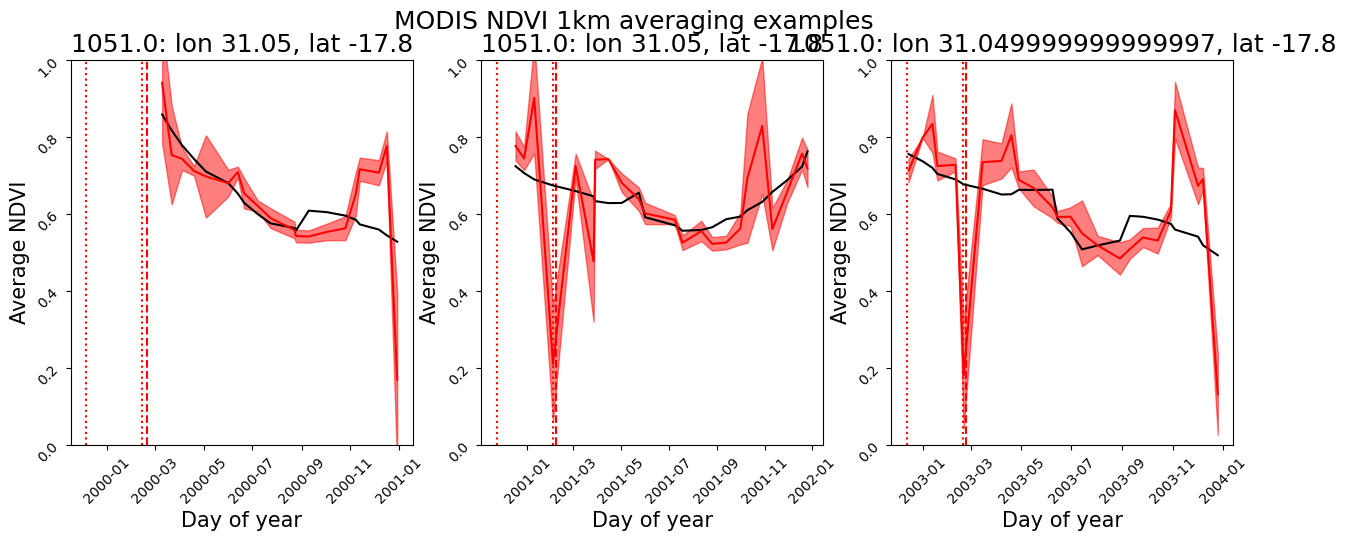

In [31]:
MODIS_at_point_averaged(coords=c_CIMMYT[:3], buffer_size = 500, year = 2001, CIMMYT = True, LULC_mask = False, 
                       suptitle = 'MODIS NDVI 1km averaging examples')

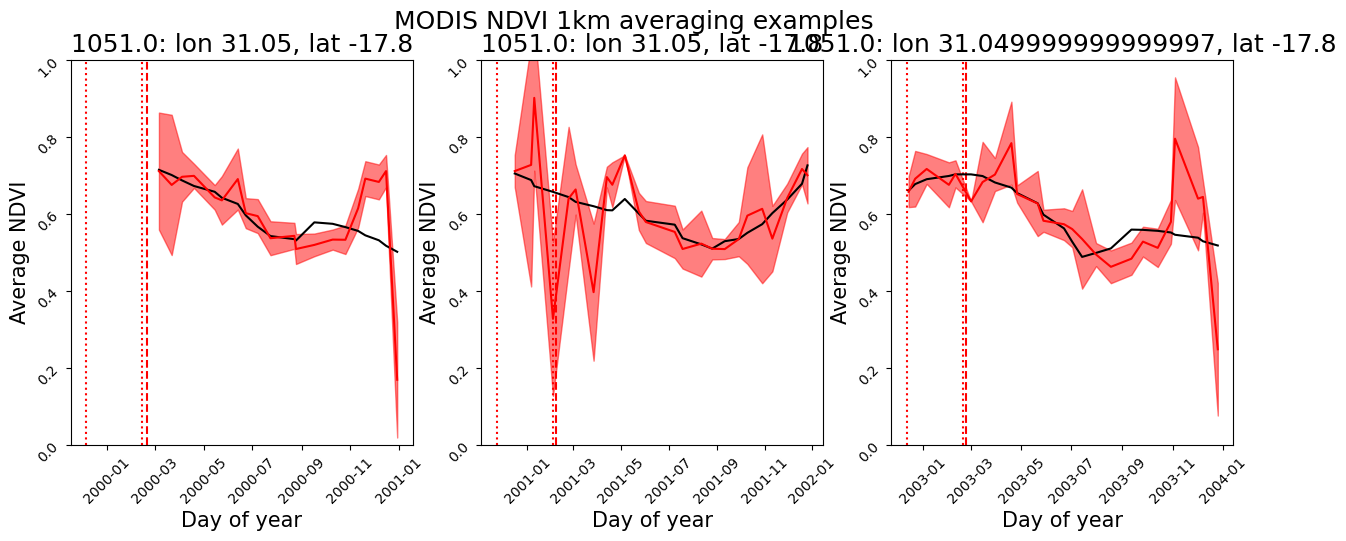

In [32]:
MODIS_at_point_averaged(coords=c_CIMMYT[:3], buffer_size = 1000, year = 2001, CIMMYT = True, LULC_mask = False, 
                       suptitle = 'MODIS NDVI 1km averaging examples')

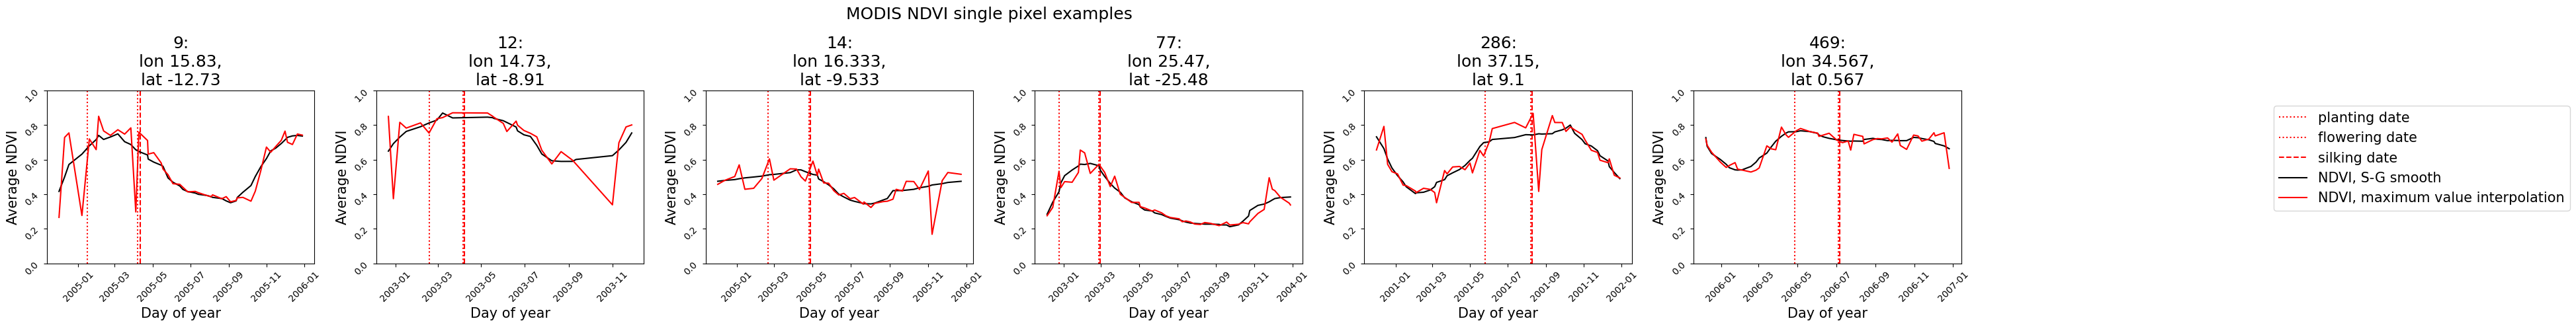

In [35]:
MODIS_at_single_point(coords=c_CIMMYT[[8, 13, 15, 25, 35, 45]], year = 2001, WC_dates=False, CIMMYT = True, TAMASA = False,
                     suptitle = 'MODIS NDVI single pixel examples')

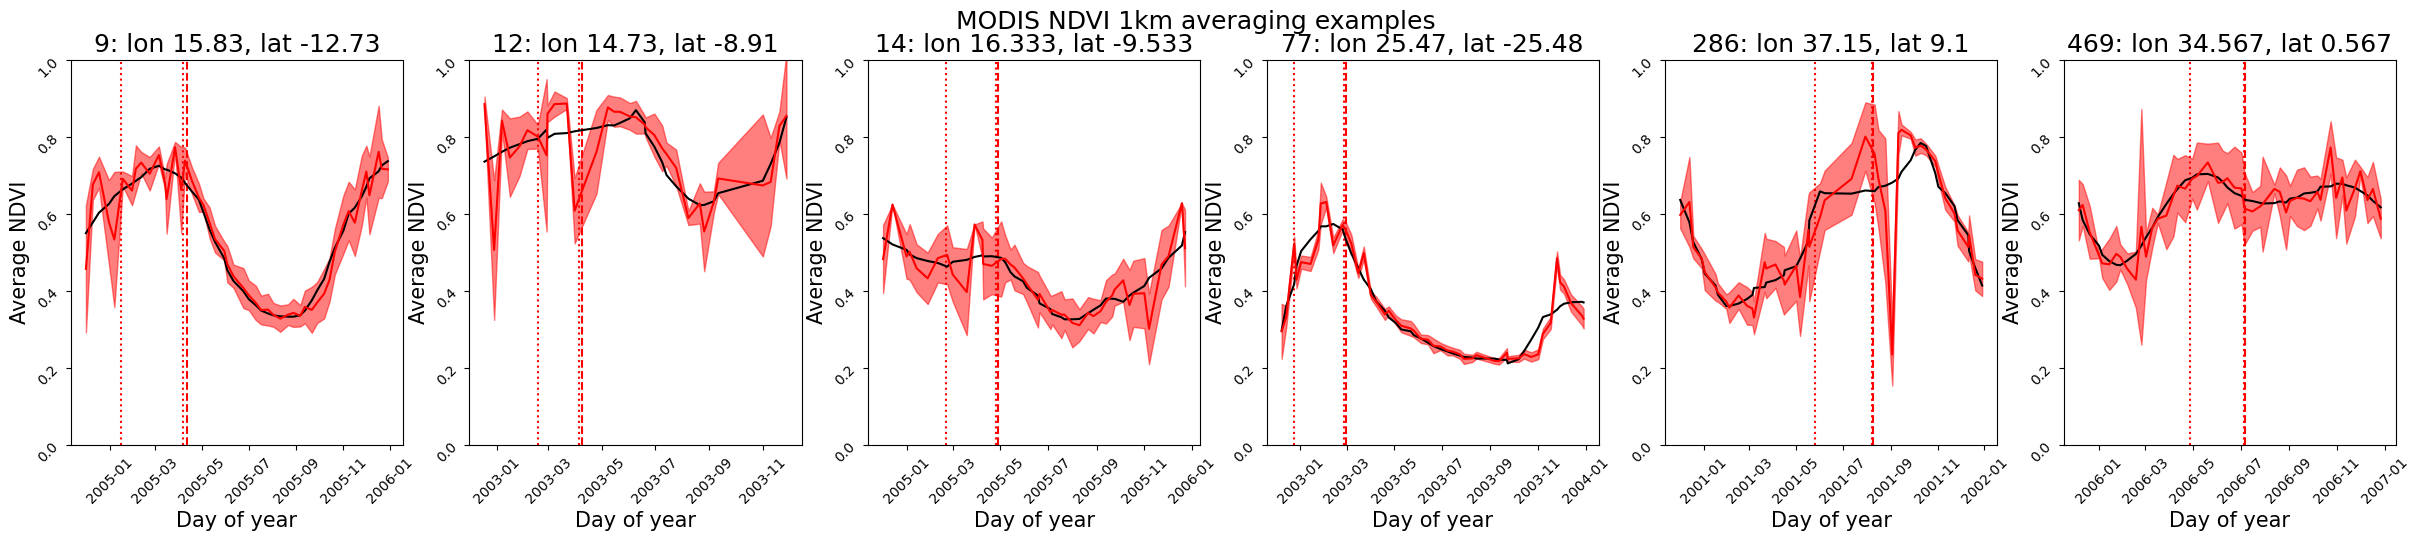

In [36]:
MODIS_at_point_averaged(coords=c_CIMMYT[[8, 13, 15, 25, 35, 45]], buffer_size = 1000, year = 2001, CIMMYT = True, LULC_mask = False, 
                       suptitle = 'MODIS NDVI 1km averaging examples')

region empty


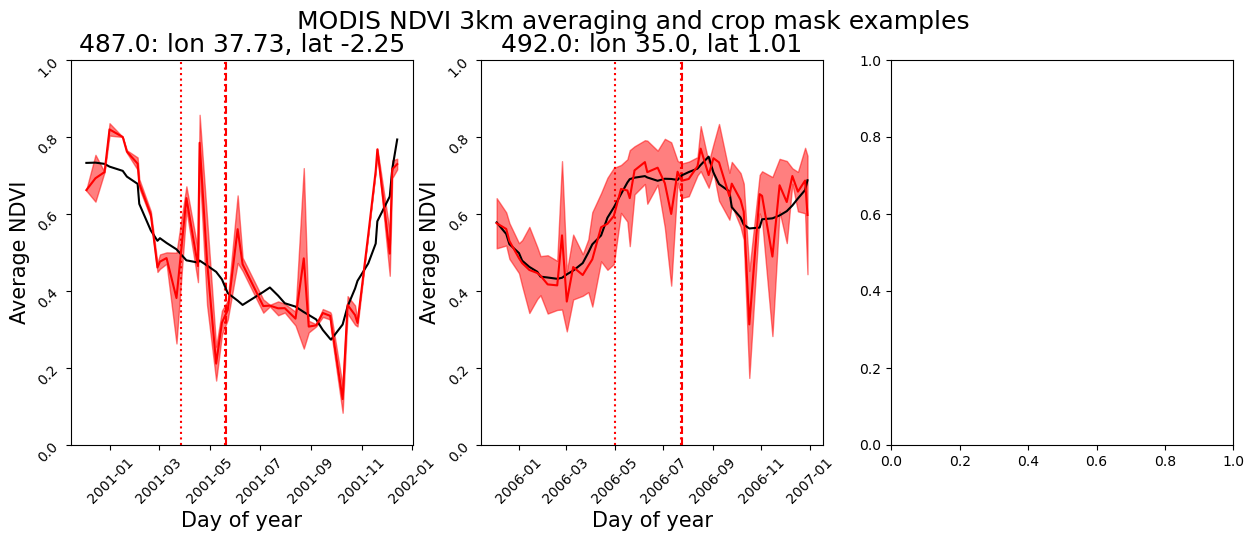

In [122]:
MODIS_at_point_averaged(coords=c_CIMMYT[[8, 13, 15]], buffer_size = 3000, year = 2001, CIMMYT = True, LULC_mask = True,
                       suptitle = 'MODIS NDVI 3km averaging and crop mask examples')
#c_CIMMYT[:3]

In [37]:
List = ee.FeatureCollection('FAO/GAUL/2015/level0').filterMetadata('ADM0_NAME','equals','Kenya').toList(999)
kenya_adm0 = ee.Feature(ee.List(List).get(0))#.first()
#print(kenya_adm0.getInfo())
kenya_coords = []
for coord in c_CIMMYT:
    point = ee.Geometry.Point([coord[1], coord[0]])
    containingFeatures = kenya_adm0.contains(point).getInfo()
    print(containingFeatures)
    if containingFeatures:
        kenya_coords.append(coord)
    #print(containingFeatures.first().get('ADM0_NAME').getInfo())
    #except:
    #    continue

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [39]:
np.array(kenya_coords)[:, 2]

array([469, 492, 918, 507, 474, 501, 487, 480], dtype=object)

In [24]:
print(containingFeatures.first().get('tc-maize-main_sos').getInfo(),
     containingFeatures.first().get('tc-maize-main_eos').getInfo(),
     containingFeatures.first().get('tc-maize-second_sos').getInfo(),
     containingFeatures.first().get('tc-maize-second_eos').getInfo(),)

260 159 46 167


In [ ]:
def get_Kenya_adm2_centroids():
    dataset = ee.FeatureCollection('FAO/GAUL/2015/level2').filterMetadata('ADM0_NAME','equals','Kenya')
    featList = dataset.toList(999)
    AEZs = ee.FeatureCollection("ESA/WorldCereal/AEZ/v100")
    coord_dataset = pd.DataFrame(columns=['adm2_name', 'lon', 'lat', 'SOS', 'EOS'])
    for adm2_index in range(74):
        f1 = ee.Feature(ee.List(featList).get(adm2_index))#38? 37?
        bundesland = f1.get('ADM2_NAME').getInfo()
        print(bundesland)
        centroid = f1.geometry().centroid().getInfo()['coordinates']
        print(centroid)
        point = ee.Geometry.Point(centroid)
        containingFeatures = AEZs.filterBounds(point)
        SOS = containingFeatures.aggregate_array('tc-maize-second_sos').getInfo()[0]
        EOS = containingFeatures.aggregate_array('tc-maize-second_eos').getInfo()[0]
        print(EOS, SOS)
        coord_dataset.loc[-1] = [bundesland, *centroid, SOS, EOS]
        coord_dataset.index = coord_dataset.index + 1
        coord_dataset = coord_dataset.sort_index()
        #print(coord_dataset)
    return coord_dataset

cd = get_Kenya_adm2_centroids()

In [10]:
kenya_coords_frame = pd.DataFrame(columns = ['lat', 'lon', 'Stations_Id'],
                            data = kenya_coords)

In [12]:
kenya_coords_frame.to_csv('Saved_files/CIMMYT_coords_Kenya.csv')

In [47]:
cd[['lon', 'lat', 'adm2_name', 'SOS', 'EOS']].to_csv('Saved_files/centroid_coords_Kenya.csv')

,lon,lat,adm2_name,SOS,EOS
0,33.967257,0.084080,Administrative unit not available,46,167
1,34.280347,0.606840,Teso,46,167
2,34.594045,0.924453,Mt Elgon,46,167
3,34.993138,0.698482,Lugari,46,167
4,34.782762,0.342335,Kakamega,46,167
...,...,...,...,...,...
69,37.018392,-1.006433,Thika,46,167
70,36.690263,-1.086267,Kiambu,46,167
71,34.903280,-1.161944,Trans Mara,46,167
72,35.706775,-1.272249,Narok,46,167


In [52]:
pd.read_csv('Saved_files/centroid_coords_Kenya.csv').drop('Unnamed: 0', axis = 1)

,lon,lat,adm2_name,SOS,EOS
0,33.967257,0.084080,Administrative unit not available,46,167
1,34.280347,0.606840,Teso,46,167
2,34.594045,0.924453,Mt Elgon,46,167
3,34.993138,0.698482,Lugari,46,167
4,34.782762,0.342335,Kakamega,46,167
...,...,...,...,...,...
69,37.018392,-1.006433,Thika,46,167
70,36.690263,-1.086267,Kiambu,46,167
71,34.903280,-1.161944,Trans Mara,46,167
72,35.706775,-1.272249,Narok,46,167
